# Showcasing the results
1. Estimation performance
2. Hypothesis testing performance

In [1]:
%load_ext autoreload
%autoreload 2
%load_ext lab_black

import matplotlib.pyplot as plt
import numpy as np
import json
import pandas as pd
import seaborn as sns
import os
import admix

In [2]:
def estimate_rg(est, est_var):
    """
    Estimate the ratio of genetic correlation.
    est: (3, ) numpy array
    est_var (3, 3) variance-covariance matrix
    """
    x, y = est[0], est[1]
    rg = y / x
    # grad = [-y / x^2, 1 / x]
    grad = np.array([-y / (x ** 2), 1 / x])

    def quad_form(x, A):
        return np.dot(np.dot(x.T, A), x)

    return rg, quad_form(grad, est_var[0:2, 0:2])

# Plot GCTA

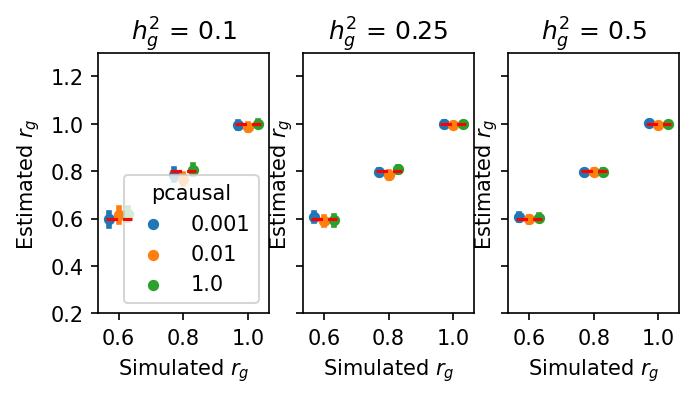

In [5]:
df_plot = []

for hsq in [0.1, 0.25, 0.5]:
    for pcausal in [0.01, 0.001, 1.0]:
        for cor in [0.6, 0.8, 1.0]:
            for hermodel in ["mafukb"]:
                for sim_i in range(100):
                    f_name = (
                        f"out/gcta-estimate/hsq-{hsq}-pcausal-{pcausal}-cor-{cor}"
                        + f"-hermodel-{hermodel}.sim_{sim_i}"
                    )
                    if not os.path.exists(f_name + ".hsq"):
                        continue
                    est = admix.tools.gcta.read_reml(f_name)
                    rg, rg_var = estimate_rg(
                        est["est"].Variance.values, est["varcov"].values
                    )
                    rg_stderr = np.sqrt(rg_var)
                    df_plot.append(
                        est["est"].Variance.values.tolist()
                        + [hsq, cor, pcausal, hermodel, rg, rg_stderr, sim_i]
                    )
df_plot = pd.DataFrame(
    df_plot,
    columns=[
        "estimated_var_g",
        "estimated_rho",
        "estimated_var_e",
        "hsq",
        "cor",
        "pcausal",
        "hermodel",
        "estimated_ratio",
        "estimated_ratio_stderr",
        "sim_i",
    ],
)

df_plot = df_plot[df_plot.estimated_ratio_stderr < 0.3]
fig, axes = plt.subplots(figsize=(5, 2.3), dpi=150, sharex=True, sharey=True, ncols=3)

for ax_i, hsq in enumerate([0.1, 0.25, 0.5]):
    df_tmp = df_plot[(df_plot.hsq == hsq)].copy()

    ax = axes[ax_i]

    sns.pointplot(
        data=df_tmp,
        x="cor",
        y="estimated_ratio",
        hue="pcausal",
        ax=ax,
        markers=".",
        dodge=0.3,
        join=False,
    )
    cor_list = sorted(df_plot.cor.unique())

    ax.hlines(
        cor_list,
        np.arange(len(cor_list)) - 0.2,
        np.arange(len(cor_list)) + 0.2,
        color="red",
        ls="--",
        zorder=10,
    )
    ax.set_ylim(0.2, 1.3)
    ax.set_xlabel("Simulated $r_g$")
    ax.set_ylabel("Estimated $r_g$")
    ax.set_title("$h_g^2$" + f" = {hsq}")
    if ax_i != 0:
        axes[ax_i].legend([], [], frameon=False)

In [6]:
df_plot.groupby(["hsq", "cor", "pcausal"]).apply(lambda x: len(x["estimated_ratio"]))

hsq   cor  pcausal
0.10  0.6  0.001       91
           0.010       87
           1.000       82
      0.8  0.001       99
           0.010       96
           1.000       94
      1.0  0.001       99
           0.010       99
           1.000       98
0.25  0.6  0.001      100
           0.010      100
           1.000      100
      0.8  0.001       98
           0.010      100
           1.000       99
      1.0  0.001      100
           0.010      100
           1.000      100
0.50  0.6  0.001      100
           0.010       99
           1.000      100
      0.8  0.001       99
           0.010      100
           1.000       96
      1.0  0.001      100
           0.010       98
           1.000       98
dtype: int64

In [7]:
rg_hat_std = df_plot.groupby(["hsq", "cor", "pcausal"]).apply(
    lambda x: np.std(x["estimated_ratio"])
)
mean_rg_std_hat = df_plot.groupby(["hsq", "cor", "pcausal"]).apply(
    lambda x: np.mean(x["estimated_ratio_stderr"])
)
df_plot = pd.DataFrame({"rg_hat_std": rg_hat_std, "mean_rg_std_hat": mean_rg_std_hat})

Text(0, 0.5, 'Mean of estimated standard error')

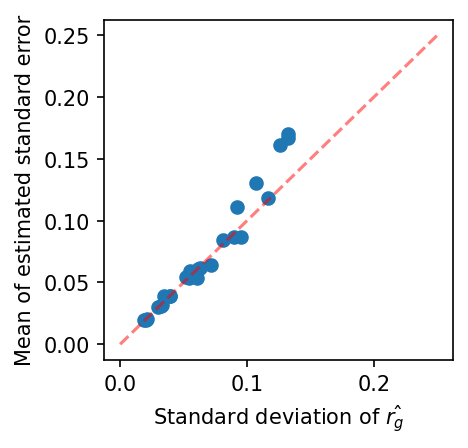

In [9]:
fig, ax = plt.subplots(figsize=(3, 3), dpi=150)
ax.scatter(df_plot.rg_hat_std, df_plot.mean_rg_std_hat)
ax.plot([0, 0.25], [0, 0.25], "r--", alpha=0.5)
ax.set_xlabel("Standard deviation of $\hat{r_g}$")
ax.set_ylabel("Mean of estimated standard error")

# Plot HE regression

In [ ]:
# rls_list = []

# for hsq in [0.1, 0.5]:
#     for pcausal in [0.01, 0.001, 1.0]:
#         for cor in [0.8, 1.0]:
#             for hermodel in ["mafukb"]:
#                 f_name = (
#                     f"out/estimate/hsq-{hsq}-pcausal-{pcausal}-cor-{cor}"
#                     + f"-hermodel-{hermodel}.estimate.json"
#                 )
#                 if not os.path.exists(f_name):
#                     continue
#                 with open(f_name) as f:
#                     data = json.load(f)

#                     df_tmp = pd.DataFrame(
#                         np.array([d["estimate"] for d in data]),
#                         columns=[
#                             "estimated_var_g",
#                             "estimated_rho",
#                             "estimated_var_e",
#                         ],
#                     )
#                     df_tmp["hsq"] = hsq
#                     df_tmp["cor"] = cor
#                     df_tmp["pcausal"] = pcausal
#                     df_tmp["hermodel"] = hermodel
#                     rls_list.append(df_tmp)

# df_plot = pd.concat(rls_list)
# df_plot["estimated_ratio"] = df_plot["estimated_rho"] / df_plot["estimated_var_g"]

# fig, axes = plt.subplots(figsize=(5, 2.3), dpi=150, sharex=True, sharey=True, ncols=2)

# for ax_i, hsq in enumerate([0.1, 0.5]):
#     df_tmp = df_plot[(df_plot.hsq == hsq)].copy()

#     ax = axes[ax_i]

#     sns.pointplot(
#         data=df_tmp,
#         x="cor",
#         y="estimated_ratio",
#         hue="pcausal",
#         ax=ax,
#         markers=".",
#         dodge=0.2,
#         join=False,
#     )
#     cor_list = sorted(df_plot.cor.unique())

#     ax.hlines(
#         cor_list,
#         np.arange(len(cor_list)) - 0.2,
#         np.arange(len(cor_list)) + 0.2,
#         color="red",
#         ls="--",
#         zorder=10,
#     )
#     ax.set_ylim(0.2, 1.3)
#     ax.set_xlabel("Simulated $r_g$")
#     ax.set_ylabel("Estimated $r_g$")
#     ax.set_title("$h_g^2$" + f" = {hsq}")
#     if ax_i != 0:
#         axes[ax_i].legend([], [], frameon=False)